# Data Analysis on VOC, COCO, and BDD100K Datasets

In [1]:
!pip install torchinfo

In [2]:
import os
from google.colab import drive
drive_path = "/content/drive"
drive.mount(drive_path)

Mounted at /content/drive


In [3]:
project_path_rel = "MyDrive/desktop/new_academia/ML_DS_Statistics/YOLO/"
project_path = os.path.join(drive_path, project_path_rel)

In [4]:
! cp -r {project_path}* ./

The goals of this notebook:
- To explain parsing structure of object detection datasets to be used for yolo model training
- Analyze data, and gather important metrics
- Compare Datasets

**Note:** This notebook might include some repetitive code since I want this to remain rather experimental.

Start with imports

In [27]:
from src import (dataParser as dp, 
                 dataLoader as dl,
                 utils)

import gc

import cv2
import skimage.io as io
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import random


import pandas
from collections import Counter

## Download Datasets
Download the compressed files for datasets.

In [6]:
# VOC
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar xvf ./VOCtrainval_11-May-2012.tar

# # COCO
# !unzip "/content/drive/MyDrive/ML_DS_Statistics/Dataset/coco/train2017.zip" -d .
!unzip "/content/drive/MyDrive/ML_DS_Statistics/Dataset/coco/annotations_trainval2017.zip" -d .

# # BDD100K LABELS
!unzip "/content/drive/MyDrive/ML_DS_Statistics/Dataset/bdd/bdd100k_det_20_labels_trainval.zip" -d .

# # BDD100K IMAGES
# !unzip "/content/drive/MyDrive/ML_DS_Statistics/Dataset/bdd/bdd100k_images_100k.zip" -d .

Streaming output truncated to the last 5000 lines.
VOCdevkit/VOC2012/SegmentationClass/2008_002032.png
VOCdevkit/VOC2012/SegmentationClass/2008_002043.png
VOCdevkit/VOC2012/SegmentationClass/2008_002064.png
VOCdevkit/VOC2012/SegmentationClass/2008_002066.png
VOCdevkit/VOC2012/SegmentationClass/2008_002067.png
VOCdevkit/VOC2012/SegmentationClass/2008_002073.png
VOCdevkit/VOC2012/SegmentationClass/2008_002079.png
VOCdevkit/VOC2012/SegmentationClass/2008_002080.png
VOCdevkit/VOC2012/SegmentationClass/2008_002123.png
VOCdevkit/VOC2012/SegmentationClass/2008_002152.png
VOCdevkit/VOC2012/SegmentationClass/2008_002160.png
VOCdevkit/VOC2012/SegmentationClass/2008_002175.png
VOCdevkit/VOC2012/SegmentationClass/2008_002177.png
VOCdevkit/VOC2012/SegmentationClass/2008_002182.png
VOCdevkit/VOC2012/SegmentationClass/2008_002200.png
VOCdevkit/VOC2012/SegmentationClass/2008_002205.png
VOCdevkit/VOC2012/SegmentationClass/2008_002210.png
VOCdevkit/VOC2012/SegmentationClass/2008_002212.png
VOCdevkit/VOC

We will parse all the individual images into following formats.

Each image:
```
image = {
          'file': {NAME_OF_FILE},
          'height': {HEIGHT_OF_IMAGE},
          'width': {WIDTH_OF_IMAGE},
          'objects: [{'bbox':[x_min,y_min,b_width,b_height], 'name': {LABEL_OF_OBJECT} }, ...]
        }
```

## VOC


### Parsing Data and Data Format

The entire dataset consists of list of these image dictionaries.

In [24]:
# Parse annotations 
train_image_folder = "VOCdevkit/VOC2012/JPEGImages/"
train_annot_folder = "VOCdevkit/VOC2012/Annotations/"

ANCHORS = np.array([1.07709888,  1.78171903,  # anchor box 1, width , height
                    2.71054693,  5.12469308,  # anchor box 2, width,  height
                   10.47181473, 10.09646365,  # anchor box 3, width,  height
                    5.48531347,  8.11011331]) # anchor box 4, width,  height

# Name of the labels in VOC
LABELS_VOC = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
              'bus',        'car',      'cat',  'chair',     'cow',
              'diningtable','dog',    'horse',  'motorbike', 'person',
              'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']

for idx, label in enumerate(LABELS_VOC):
  LABELS_VOC[idx] = dp.cat_name_COCO_to_VOC(label)


In [25]:
train_image_voc = dp.parse_annotation_VOC(train_annot_folder,train_image_folder, labels=LABELS_VOC)

In [26]:
train_image_voc[0]

{'file': 'VOCdevkit/VOC2012/JPEGImages/2007_000027.jpg',
 'height': 500,
 'objects': [{'bbox': [174, 101, 175, 250], 'name': 'person'}],
 'width': 486}

In [17]:
type(train_image_voc)

list

In [28]:
random.seed(42)
random.shuffle(train_image_voc)

One change we made is about the coordinates of bounding boxes. In the format provided by VOC data, the coordinates of bounding boxes are given by x_min, y_min, x_max, y_max. I stick with the formulation above, and changed these into x_min, y_min, width, height. This is the format followed by MS COCO dataset.

Another change is about the name of a few classes. For instance, VOC uses 'aeroplane' whereas COCO uses 'airplane'. I changed these names in VOC with `cat_name_COCO_to_VOC` function

### Analysis

Let's start our analysis with the distribution of classes.

In [29]:
# Name useful for plotting
VOC_NAME = "PASCAL VOC"
# Gather all objects in a list
all_objects = []

for i in train_image_voc[:15000]:
  obj_arr =  i['objects']

  for obj in obj_arr:
    all_objects.append(obj['name'])

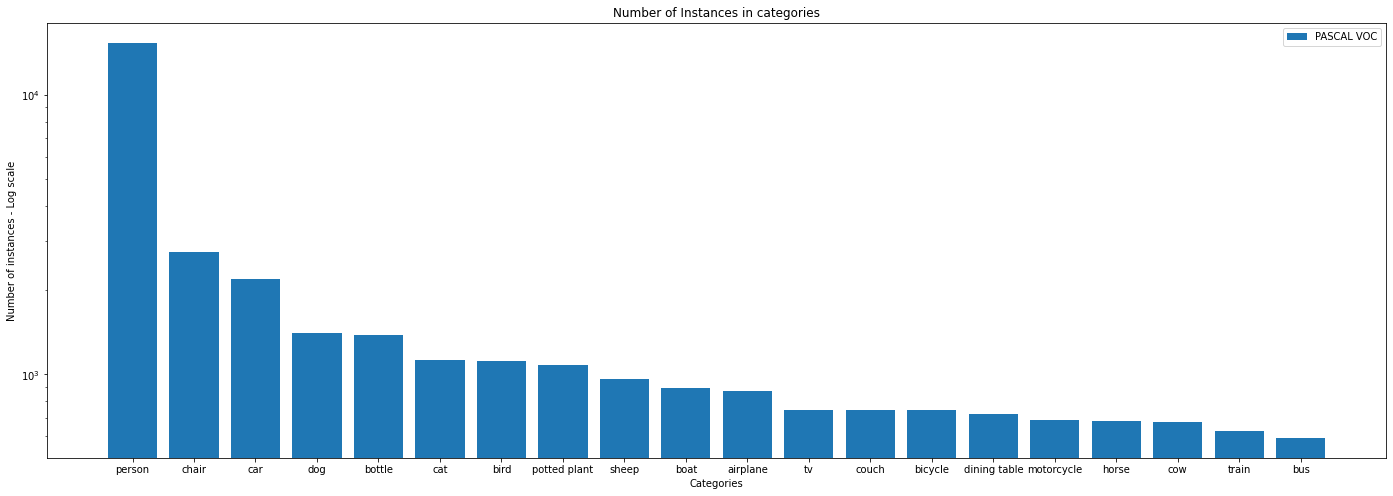

In [30]:
# Count instances in images
cat_counts = Counter(all_objects)
df = pandas.DataFrame.from_dict(cat_counts, orient='index')
df.sort_values(by=[0], inplace=True, ascending=False)

# Figure and plot
fig, ax = plt.subplots(figsize=(24,8))
x = df.index.values
y = df[0].values

# Bar graph
ax.bar(x=x, height=y)

# Settings
ax.set_title("Number of Instances in categories")
ax.set_xlabel("Categories")
ax.set_ylabel("Number of instances - Log scale")
ax.set_yscale('log')
ax.legend([VOC_NAME])

plt.show()


In [31]:
# Name useful for plotting
VOC_NAME = "PASCAL VOC"
# Gather all objects in a list
all_objects = []

for i in train_image_voc[15000:]:
  obj_arr =  i['objects']

  for obj in obj_arr:
    all_objects.append(obj['name'])

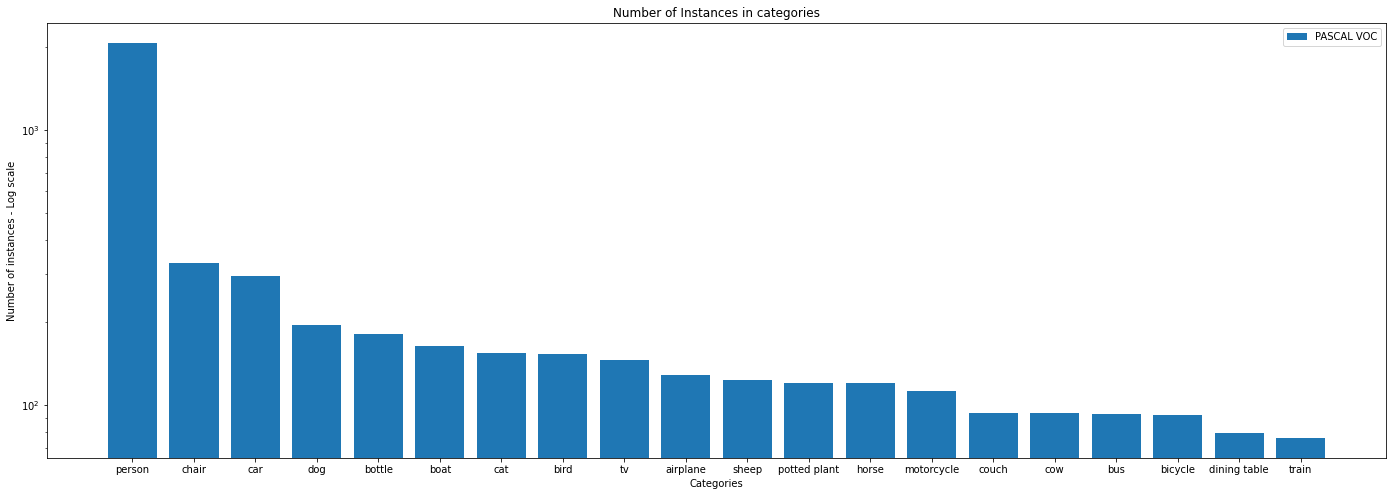

In [32]:
# Count instances in images
cat_counts = Counter(all_objects)
df = pandas.DataFrame.from_dict(cat_counts, orient='index')
df.sort_values(by=[0], inplace=True, ascending=False)

# Figure and plot
fig, ax = plt.subplots(figsize=(24,8))
x = df.index.values
y = df[0].values

# Bar graph
ax.bar(x=x, height=y)

# Settings
ax.set_title("Number of Instances in categories")
ax.set_xlabel("Categories")
ax.set_ylabel("Number of instances - Log scale")
ax.set_yscale('log')
ax.legend([VOC_NAME])

plt.show()


We see that the number person instances is pretty dominant over other classes, while others having rather uniform distribution among themselves.

These kind of skewness might be useful when makin error analysis after training.

We can visualize skewness with portion of class vs number of classes

In [ ]:
df['cum_percent'] = 100*(df[0][::-1].cumsum() / df[0].sum())

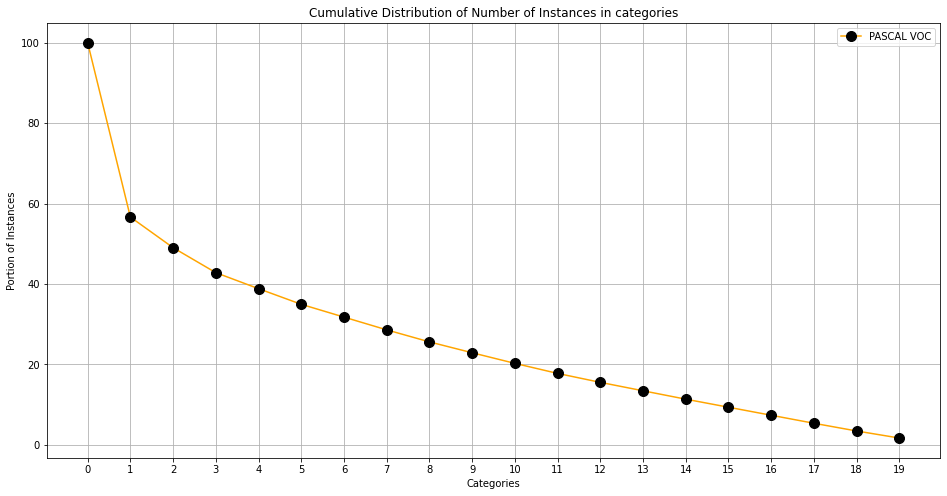

In [ ]:
# Figure and plot
fig, ax = plt.subplots(figsize=(16,8))
y = df['cum_percent']
x = np.arange(len(y))

# Scatter plot
ax.plot(x, y,  markersize=10, color="orange", marker='o', mfc='black', mec='black')

# Settings
ax.set_title("Cumulative Distribution of Number of Instances in categories")
ax.set_xticks(x)
ax.set_xlabel("Categories")
ax.set_ylabel( "Portion of Instances")
ax.legend([VOC_NAME])
ax.grid()

plt.show()



Now, look at the distribution of count of instances per image. Namely, let see what portion of images includes 1 object, 2 objects, 3 objects, etc.

In [ ]:
# Gather all objects in a list
object_cnts_img = []

for i in train_image_voc:
  object_cnts_img.append(len(i['objects']))

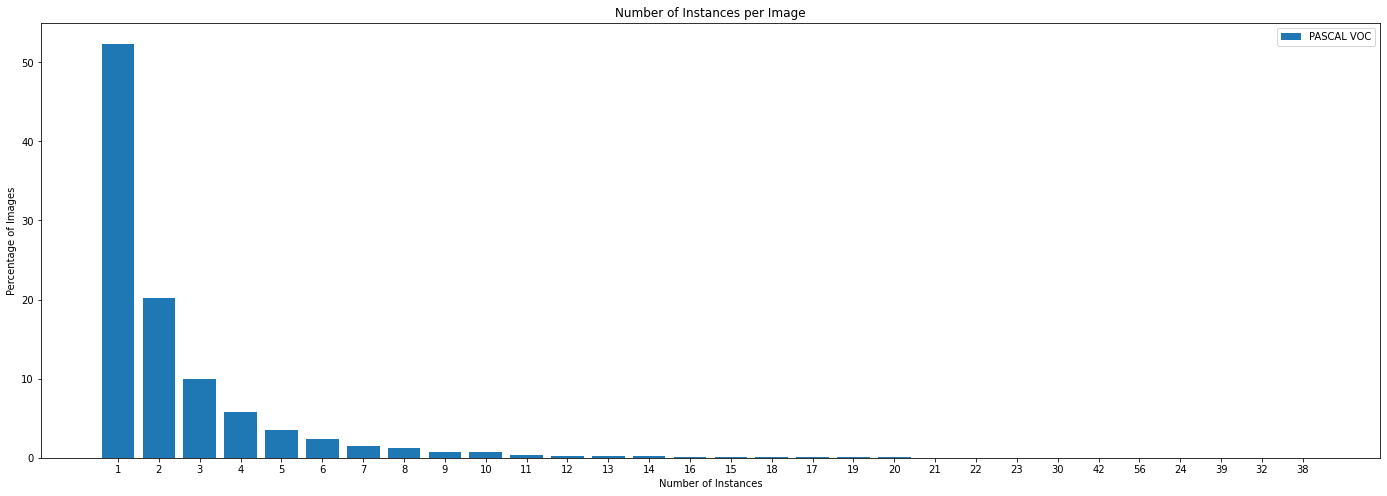

In [ ]:
# Count number of instances in images
obj_counts = Counter(object_cnts_img)
df = pandas.DataFrame.from_dict(obj_counts, orient='index')

df[0] *= 100/len(train_image_voc)
df.sort_values(by=[0], inplace=True, ascending=False)

# Figure and plot
fig, ax = plt.subplots(figsize=(24,8))
x_tick = df.index.values
y = df[0].values
x = np.arange(len(y))

# Bar graph
ax.bar(x, height=y)

# Settings
ax.set_title("Number of Instances per Image")
ax.set_xticks(x)
ax.set_xticklabels(x_tick)
ax.set_xlabel("Number of Instances")
ax.set_ylabel("Percentage of Images")
ax.legend([VOC_NAME])

plt.show()

We see that number single objects are very dominant event there are important number of muliple objcts images up to 6,7 objects. Again, this metric might become useful if we train our models merely based on VOC dataset and when model does not do well on images with cluster of objects.

Another similar metric to look at the diversity of objects. Namely, we want to how many images contain 2,3,4,5,... distinct categories

In [ ]:
# Gather all objects in a list
cat_cnt_imgs = []

for i in train_image_voc:
  obj_arr =  i['objects']
  cat_per_img = []
  for obj in obj_arr:
    cat_per_img.append(obj['name'])
  
  # Get the number of unique categories
  cat_cnt_imgs.append(len(set(cat_per_img)))

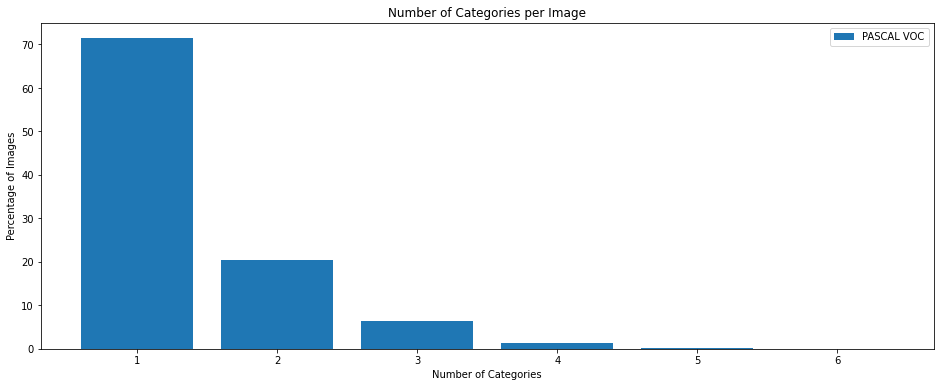

In [ ]:
# Count number of categories in images
obj_cat_counts = Counter(cat_cnt_imgs)
df = pandas.DataFrame.from_dict(obj_cat_counts, orient='index')

df[0] *= 100/len(train_image_voc)
df.sort_values(by=[0], inplace=True, ascending=False)

# Figure and plot
fig, ax = plt.subplots(figsize=(16,6))
x_tick = df.index.values
y = df[0].values
x = np.arange(len(y))

# Bar graph
ax.bar(x, height=y)

# Settings
ax.set_title("Number of Categories per Image")
ax.set_xticks(x)
ax.set_xticklabels(x_tick)
ax.set_xlabel("Number of Categories")
ax.set_ylabel("Percentage of Images")
ax.legend([VOC_NAME])

plt.show()

Now, we look at the distrbiution of image resolution, i.e. image size. This becomes important since the scale of images will affect the performance.

In [ ]:
# Gather distrbution of height and width
height_dist = []
width_dist = []

for data_instance in train_image_voc:
  height_dist.append(data_instance['height'])
  width_dist.append(data_instance['width'])

height_dist = np.array(height_dist)
width_dist = np.array(width_dist)

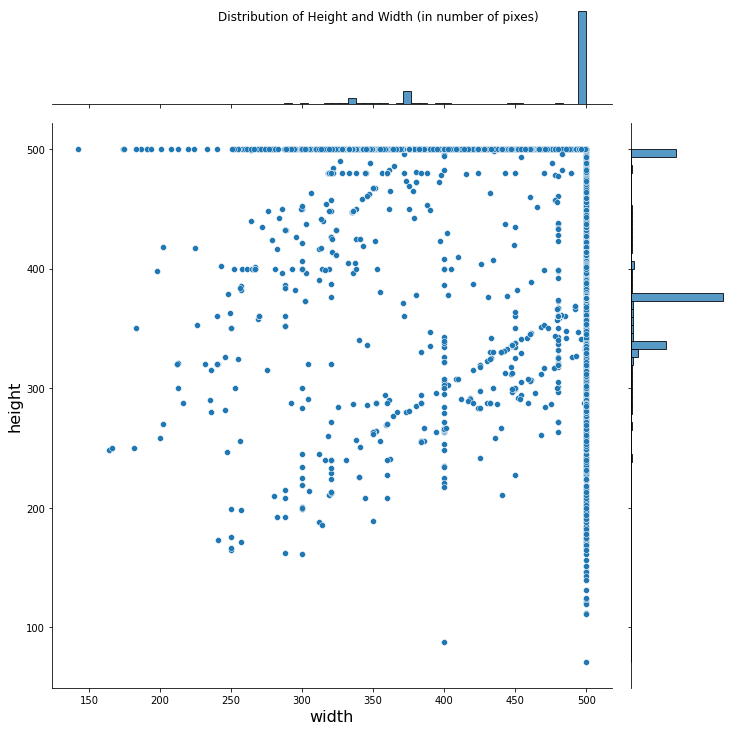

In [ ]:
number_bins = 64
img_grid = sns.jointplot(x=width_dist, y=height_dist,
                marginal_kws=dict(bins=number_bins),
                height=10)

img_grid.set_axis_labels('width', 'height', fontsize=16)
plt.suptitle("Distribution of Height and Width (in number of pixes)")

plt.show()

Next, we look at the distrbuito of size of objects. Smaller objects are harder to recognize and requieres more contextual information

In [ ]:
# Gather distrbution of object height and width
obj_height_dist = []
obj_width_dist = []

for data_instance in train_image_voc:

  for obj in data_instance['objects']:
    obj_width_dist.append(obj['bbox'][2])
    obj_height_dist.append(obj['bbox'][3])

obj_height_dist = np.array(obj_height_dist)
obj_width_dist = np.array(obj_width_dist)

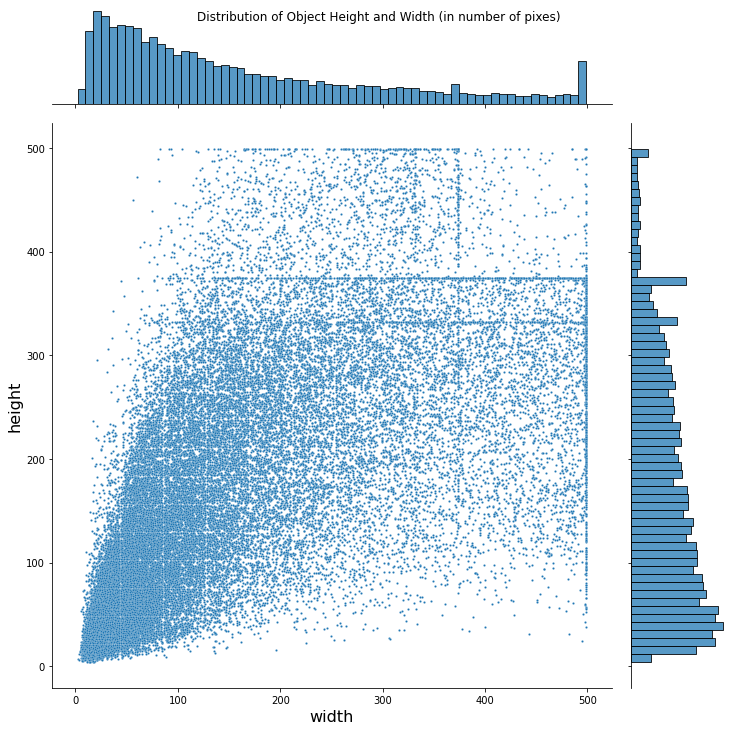

In [ ]:
number_bins = 64
img_grid = sns.jointplot(x=obj_width_dist, y=obj_height_dist,
                marginal_kws=dict(bins=number_bins, ),
                height=10, s=5)

img_grid.set_axis_labels('width', 'height', fontsize=16)
plt.suptitle("Distribution of Object Height and Width (in number of pixes)")

plt.show()

## MS COCO

### Parsing Data and Data Format

In [ ]:
dataDir='.'
dataType='train2017'
annFile=f"{dataDir}/annotations/instances_{dataType}.json"

In [ ]:
my_json = json.load(open(annFile, 'r'))

In [ ]:
id_to_image = dp.COCO_json_img(my_json)
id_to_cat = dp.COCO_json_cat(my_json)
id_to_image = dp.attach_objs(id_to_image, id_to_cat, my_json)

In [ ]:
del my_json
gc.collect()

50

In [ ]:
LABELS = list(id_to_cat.values())
for i in LABELS_VOC:
  if i not in LABELS:
    print("no")

In [ ]:
train_image_coco = list(id_to_image.values())
print(LABELS[:4])
train_image_coco[0]

['person', 'bicycle', 'car', 'motorcycle']


{'file': 'http://images.cocodataset.org/train2017/000000391895.jpg',
 'height': 360,
 'objects': [{'bbox': [359.17, 146.17, 112.45, 213.57], 'name': 'motorcycle'},
  {'bbox': [339.88, 22.16, 153.88, 300.73], 'name': 'person'},
  {'bbox': [471.64, 172.82, 35.92, 48.1], 'name': 'person'},
  {'bbox': [486.01, 183.31, 30.63, 34.98], 'name': 'bicycle'}],
 'width': 640}

### Analysis

In [ ]:
# Name useful for plotting
COCO_NAME = "MS COCO"
# Gather all objects in a list
all_objects = []

for i in train_image_coco:
  obj_arr =  i['objects']

  for obj in obj_arr:
    all_objects.append(obj['name'])

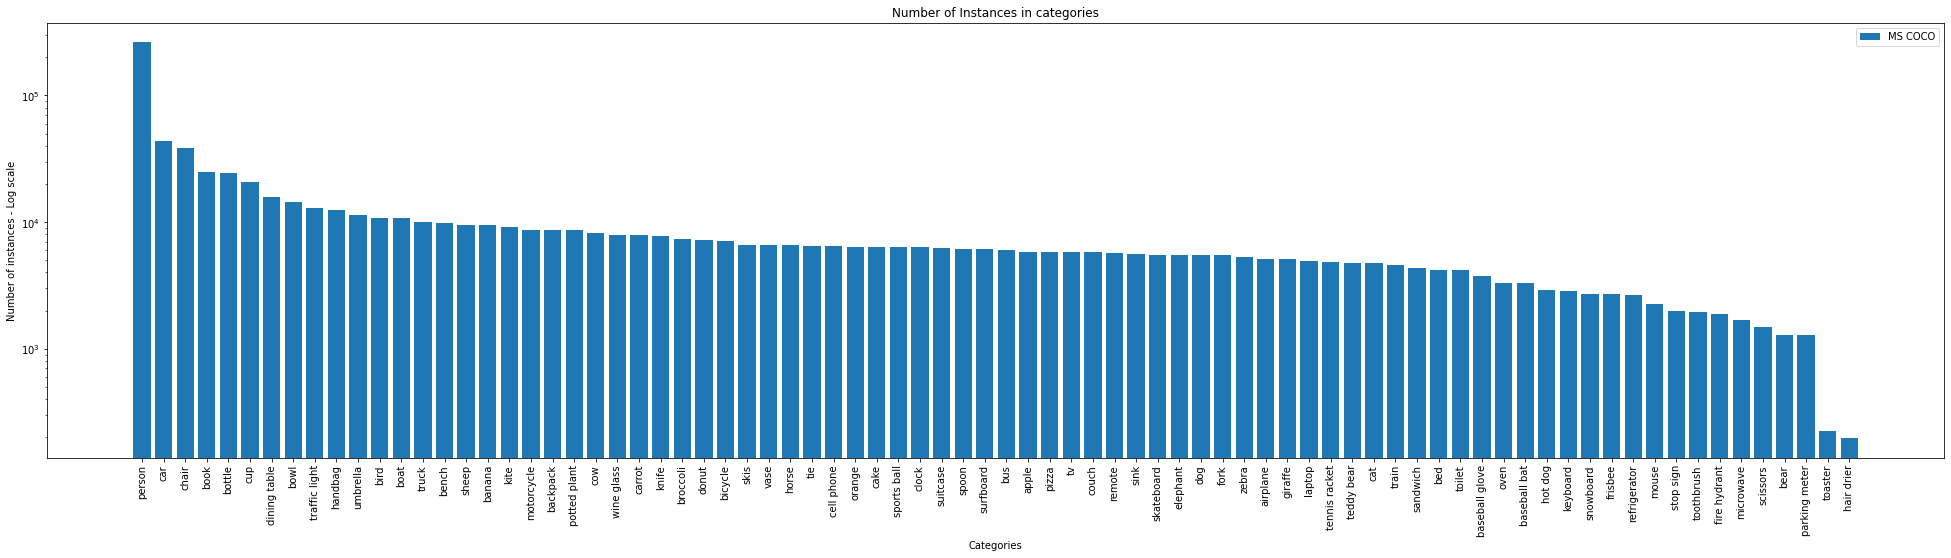

In [ ]:
# Count instances in images
cat_counts = Counter(all_objects)
df = pandas.DataFrame.from_dict(cat_counts, orient='index')
df.sort_values(by=[0], inplace=True, ascending=False)

# Figure and plot
fig, ax = plt.subplots(figsize=(34,8))
x = df.index.values
y = df[0].values

# Bar graph
ax.bar(x=x, height=y)

# Settings
ax.set_title("Number of Instances in categories")
ax.set_xlabel("Categories")
ax.set_ylabel("Number of instances - Log scale")
ax.set_yscale('log')
ax.set_xticklabels(x, rotation=90)
ax.legend([COCO_NAME])

plt.show()


Similar to VOC, person class is dominant and the others are uniform amongst themselves

In [ ]:
df['cum_percent'] = 100*(df[0][::-1].cumsum() / df[0].sum())

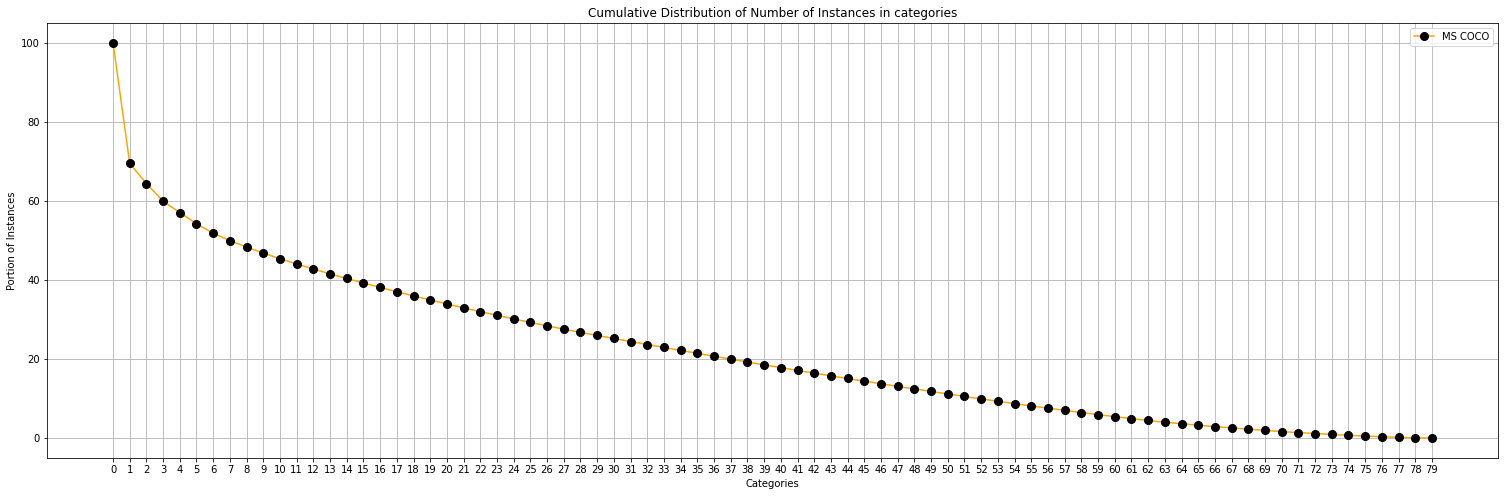

In [ ]:
# Figure and plot
fig, ax = plt.subplots(figsize=(26,8))
y = df['cum_percent']
x = np.arange(len(y))

# Scatter plot
ax.plot(x, y,  markersize=8, color="orange", marker='o', mfc='black', mec='black')

# Settings
ax.set_title("Cumulative Distribution of Number of Instances in categories")
ax.set_xticks(x)
ax.set_xlabel("Categories")
ax.set_ylabel( "Portion of Instances")
ax.legend([COCO_NAME])
ax.grid()

plt.show()

Now, look at the distribution of count of instances per image. Namely, let see what portion of images includes 1 object, 2 objects, 3 objects, etc.

In [ ]:
# Gather all objects in a list
object_cnts_img = []

for i in train_image_coco:
  object_cnts_img.append(len(i['objects']))

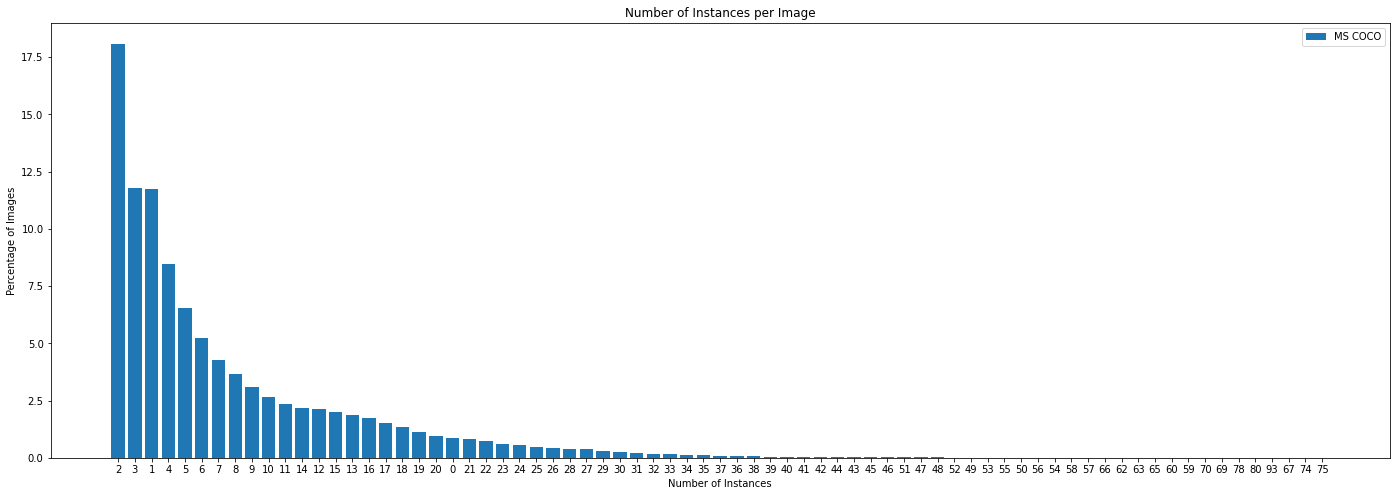

In [ ]:
# Count number of instances in images
obj_counts = Counter(object_cnts_img)
df = pandas.DataFrame.from_dict(obj_counts, orient='index')

df[0] *= 100/len(train_image_coco)
df.sort_values(by=[0], inplace=True, ascending=False)

# Figure and plot
fig, ax = plt.subplots(figsize=(24,8))
x_tick = df.index.values
y = df[0].values
x = np.arange(len(y))

# Bar graph
ax.bar(x, height=y)

# Settings
ax.set_title("Number of Instances per Image")
ax.set_xticks(x)
ax.set_xticklabels(x_tick)
ax.set_xlabel("Number of Instances")
ax.set_ylabel("Percentage of Images")
ax.legend([COCO_NAME])

plt.show()

In [ ]:
# Gather all objects in a list
cat_cnt_imgs = []

for i in train_image_coco:
  obj_arr =  i['objects']
  cat_per_img = []
  for obj in obj_arr:
    cat_per_img.append(obj['name'])
  
  # Get the number of unique categories
  cat_cnt_imgs.append(len(set(cat_per_img)))

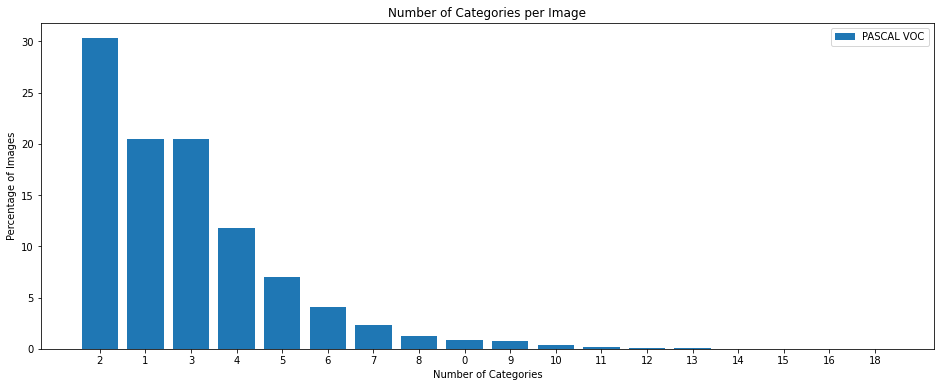

In [ ]:
# Count number of categories in images
obj_cat_counts = Counter(cat_cnt_imgs)
df = pandas.DataFrame.from_dict(obj_cat_counts, orient='index')

df[0] *= 100/len(train_image_coco)
df.sort_values(by=[0], inplace=True, ascending=False)

# Figure and plot
fig, ax = plt.subplots(figsize=(16,6))
x_tick = df.index.values
y = df[0].values
x = np.arange(len(y))

# Bar graph
ax.bar(x, height=y)

# Settings
ax.set_title("Number of Categories per Image")
ax.set_xticks(x)
ax.set_xticklabels(x_tick)
ax.set_xlabel("Number of Categories")
ax.set_ylabel("Percentage of Images")
ax.legend([VOC_NAME])

plt.show()

Now, we look at the distrbiution of image resolution, i.e. image size. This becomes important since the scale of images will affect the performance.

In [ ]:
# Gather distrbution of height and width
height_dist = []
width_dist = []

for data_instance in train_image_coco:
  height_dist.append(data_instance['height'])
  width_dist.append(data_instance['width'])

height_dist = np.array(height_dist)
width_dist = np.array(width_dist)

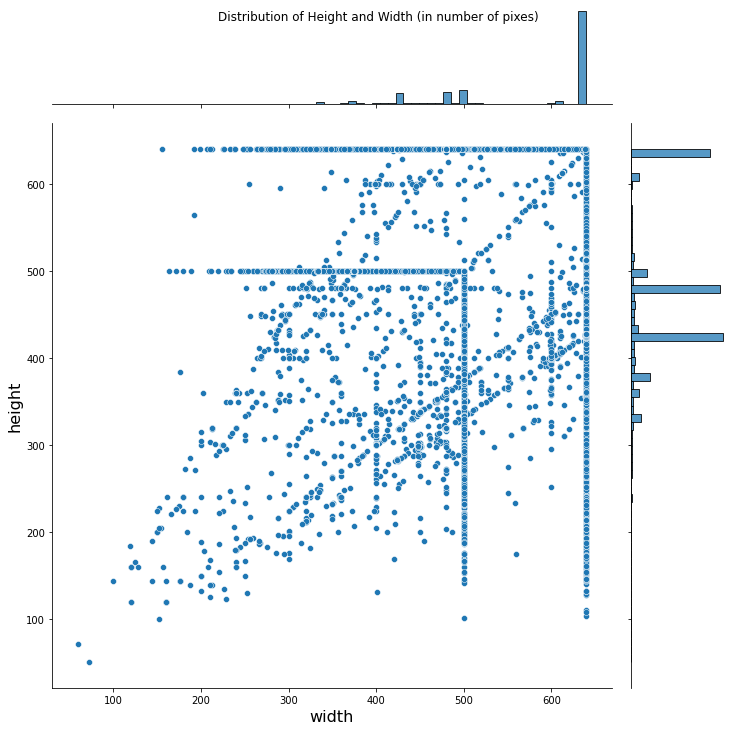

In [ ]:
number_bins = 64
img_grid = sns.jointplot(x=width_dist, y=height_dist,
                marginal_kws=dict(bins=number_bins),
                height=10)

img_grid.set_axis_labels('width', 'height', fontsize=16)
plt.suptitle("Distribution of Height and Width (in number of pixes)")

plt.show()

Next, we look at the distrbuito of size of objects. Smaller objects are harder to recognize and requieres more contextual information

In [ ]:
# Gather distrbution of object height and width
obj_height_dist = []
obj_width_dist = []

for data_instance in train_image_coco:

  for obj in data_instance['objects']:
    obj_width_dist.append(obj['bbox'][2])
    obj_height_dist.append(obj['bbox'][3])

obj_height_dist = np.array(obj_height_dist)
obj_width_dist = np.array(obj_width_dist)

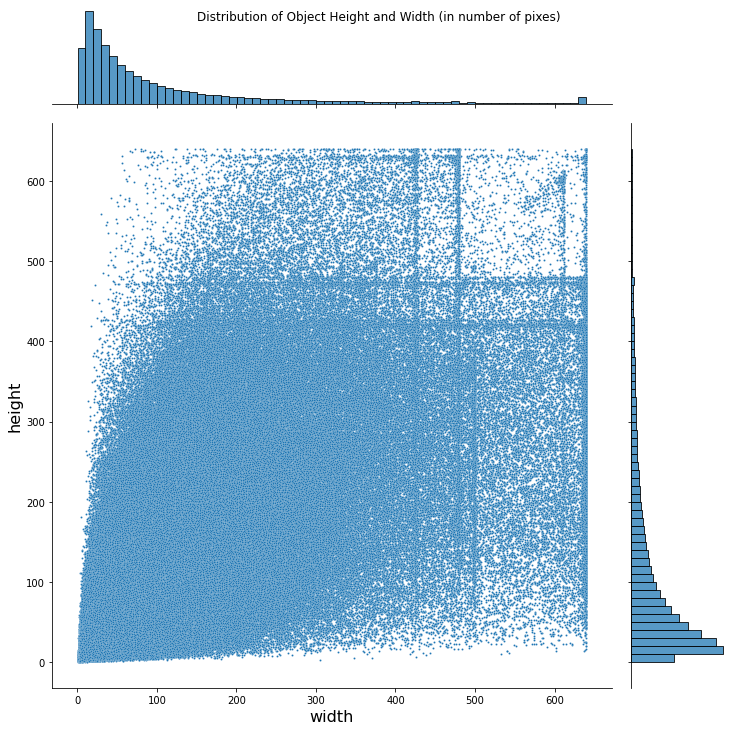

In [ ]:
number_bins = 64
img_grid = sns.jointplot(x=obj_width_dist, y=obj_height_dist,
                marginal_kws=dict(bins=number_bins, ),
                height=10, s=4)

img_grid.set_axis_labels('width', 'height', fontsize=16)
plt.suptitle("Distribution of Object Height and Width (in number of pixes)")

plt.show()

## BDD100K

### Parsing Data and Data Format

Use det_20 not since they are revised version of original release, which is contained in bdd100k_labels_realease.zip

Also we dont use tracking dataset since these subset of the original dataset specialized for trackign objects

In [ ]:
dataDir='.'
dataType='train'
img_folder = './bdd100k/images/100k/train/'
annFile=f"{dataDir}/bdd100k/labels/det_20/det_{dataType}.json"

In [ ]:
my_json = json.load(open(annFile, 'r'))

In [ ]:
train_image_bdd = dp.bdd_to_format(my_json, img_folder, is_attributes=True)
train_image_bdd[0]

{'attributes': {'scene': 'city street',
  'timeofday': 'daytime',
  'weather': 'clear'},
 'file': './bdd100k/images/100k/train/0000f77c-6257be58.jpg',
 'height': 700,
 'objects': [{'attributes': {'occluded': False,
    'trafficLightColor': 'G',
    'truncated': False},
   'bbox': [1125.902264, 133.184488, 31.076380999999856, 77.69095700000003],
   'name': 'traffic light'},
  {'attributes': {'occluded': False,
    'trafficLightColor': 'G',
    'truncated': False},
   'bbox': [1156.978645, 136.637417, 34.529315, 74.23802599999999],
   'name': 'traffic light'},
  {'attributes': {'occluded': False,
    'trafficLightColor': 'NA',
    'truncated': False},
   'bbox': [1105.66915985699,
    211.122087,
    65.12121014300988,
    22.444053999999994],
   'name': 'traffic sign'},
  {'attributes': {'occluded': False,
    'trafficLightColor': 'NA',
    'truncated': True},
   'bbox': [0.0, 0.246631, 100.381647, 122.579065],
   'name': 'traffic sign'},
  {'attributes': {'occluded': False,
    'traffi

### Analysis

In [ ]:
# Name useful for plotting
BDD_NAME = "BDD100K"
# Gather all objects in a list
all_objects = []

for i in train_image_bdd:
  obj_arr =  i['objects']

  for obj in obj_arr:
    all_objects.append(obj['name'])

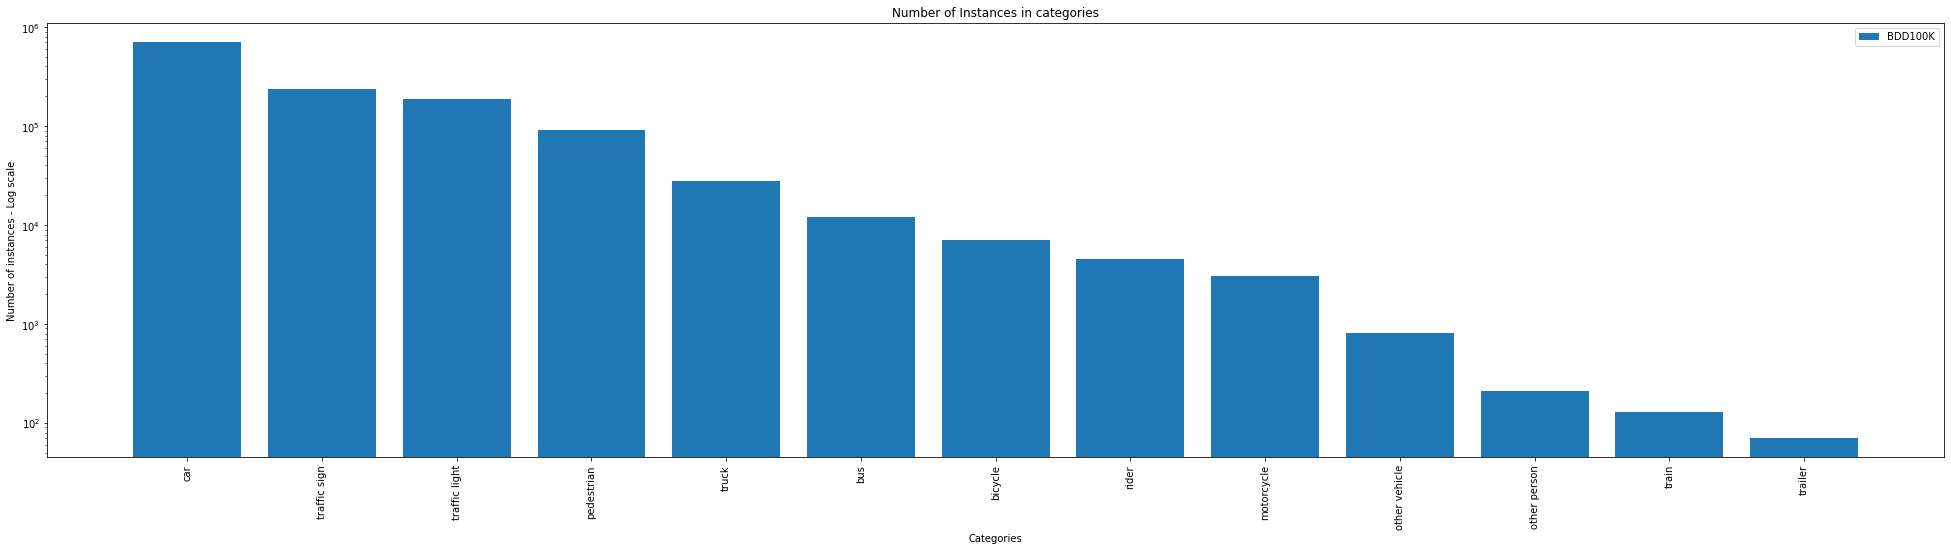

In [ ]:
# Count instances in images
cat_counts = Counter(all_objects)
df = pandas.DataFrame.from_dict(cat_counts, orient='index')
df.sort_values(by=[0], inplace=True, ascending=False)

# Figure and plot
fig, ax = plt.subplots(figsize=(34,8))
x = df.index.values
y = df[0].values

# Bar graph
ax.bar(x=x, height=y)

# Settings
ax.set_title("Number of Instances in categories")
ax.set_xlabel("Categories")
ax.set_ylabel("Number of instances - Log scale")
ax.set_yscale('log')
ax.set_xticklabels(x, rotation=90)
ax.legend([BDD_NAME])

plt.show()


In [ ]:
df['cum_percent'] = 100*(df[0][::-1].cumsum() / df[0].sum())

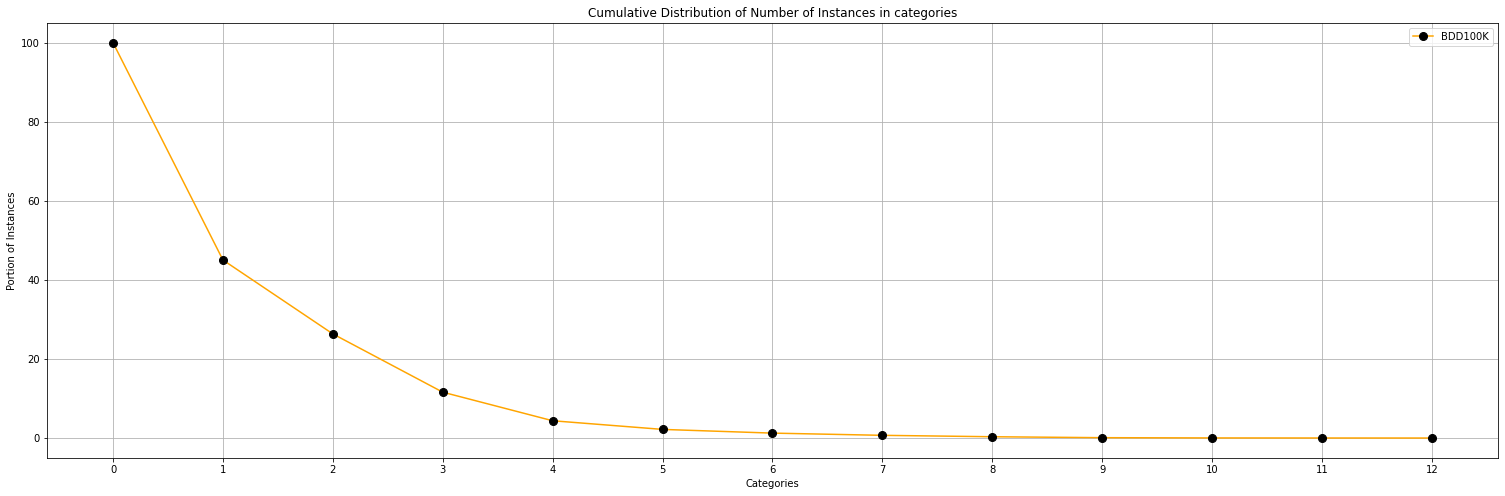

In [ ]:
# Figure and plot
fig, ax = plt.subplots(figsize=(26,8))
y = df['cum_percent']
x = np.arange(len(y))

# Scatter plot
ax.plot(x, y,  markersize=8, color="orange", marker='o', mfc='black', mec='black')

# Settings
ax.set_title("Cumulative Distribution of Number of Instances in categories")
ax.set_xticks(x)
ax.set_xlabel("Categories")
ax.set_ylabel( "Portion of Instances")
ax.legend([BDD_NAME])
ax.grid()

plt.show()

In [ ]:
# Gather all objects in a list
object_cnts_img = []

for i in train_image_bdd:
  object_cnts_img.append(len(i['objects']))

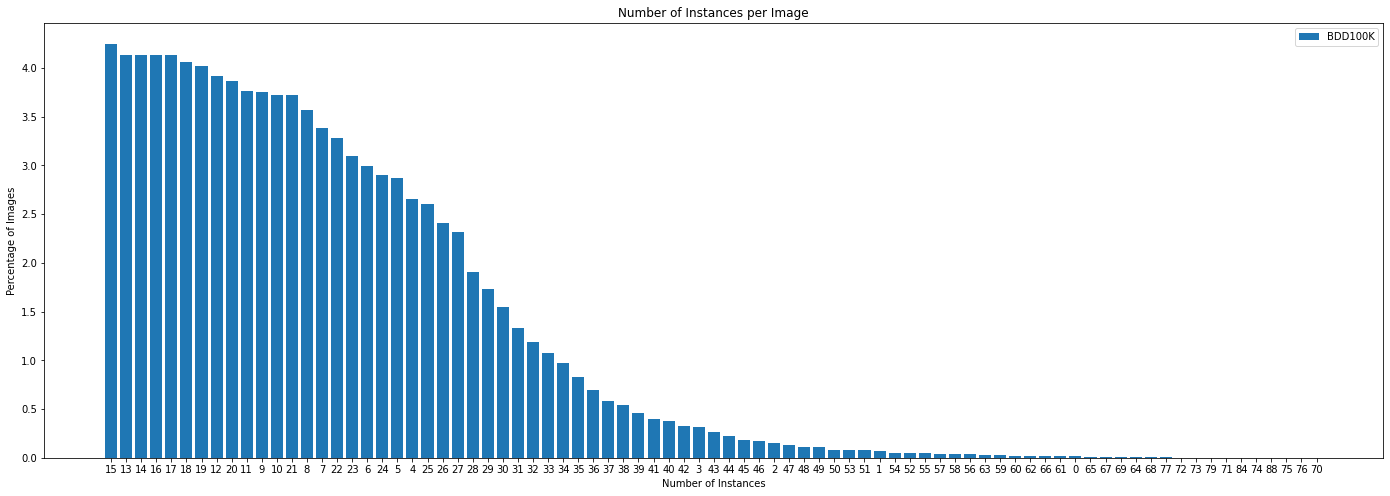

In [ ]:
# Count number of instances in images
obj_counts = Counter(object_cnts_img)
df = pandas.DataFrame.from_dict(obj_counts, orient='index')

df[0] *= 100/len(train_image_bdd)
df.sort_values(by=[0], inplace=True, ascending=False)

# Figure and plot
fig, ax = plt.subplots(figsize=(24,8))
x_tick = df.index.values
y = df[0].values
x = np.arange(len(y))

# Bar graph
ax.bar(x, height=y)

# Settings
ax.set_title("Number of Instances per Image")
ax.set_xticks(x)
ax.set_xticklabels(x_tick)
ax.set_xlabel("Number of Instances")
ax.set_ylabel("Percentage of Images")
ax.legend([BDD_NAME])

plt.show()

In [ ]:
# Gather all objects in a list
cat_cnt_imgs = []

for i in train_image_bdd:
  obj_arr =  i['objects']
  cat_per_img = []
  for obj in obj_arr:
    cat_per_img.append(obj['name'])
  
  # Get the number of unique categories
  cat_cnt_imgs.append(len(set(cat_per_img)))

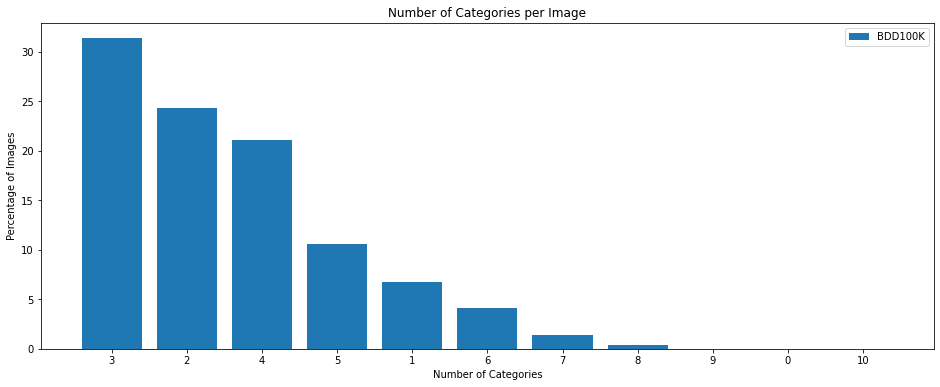

In [ ]:
# Count number of categories in images
obj_cat_counts = Counter(cat_cnt_imgs)
df = pandas.DataFrame.from_dict(obj_cat_counts, orient='index')

df[0] *= 100/len(train_image_bdd)
df.sort_values(by=[0], inplace=True, ascending=False)

# Figure and plot
fig, ax = plt.subplots(figsize=(16,6))
x_tick = df.index.values
y = df[0].values
x = np.arange(len(y))

# Bar graph
ax.bar(x, height=y)

# Settings
ax.set_title("Number of Categories per Image")
ax.set_xticks(x)
ax.set_xticklabels(x_tick)
ax.set_xlabel("Number of Categories")
ax.set_ylabel("Percentage of Images")
ax.legend([BDD_NAME])

plt.show()

In [ ]:
# Gather distrbution of height and width
height_dist = []
width_dist = []

for data_instance in train_image_bdd:
  height_dist.append(data_instance['height'])
  width_dist.append(data_instance['width'])

height_dist = np.array(height_dist)
width_dist = np.array(width_dist)

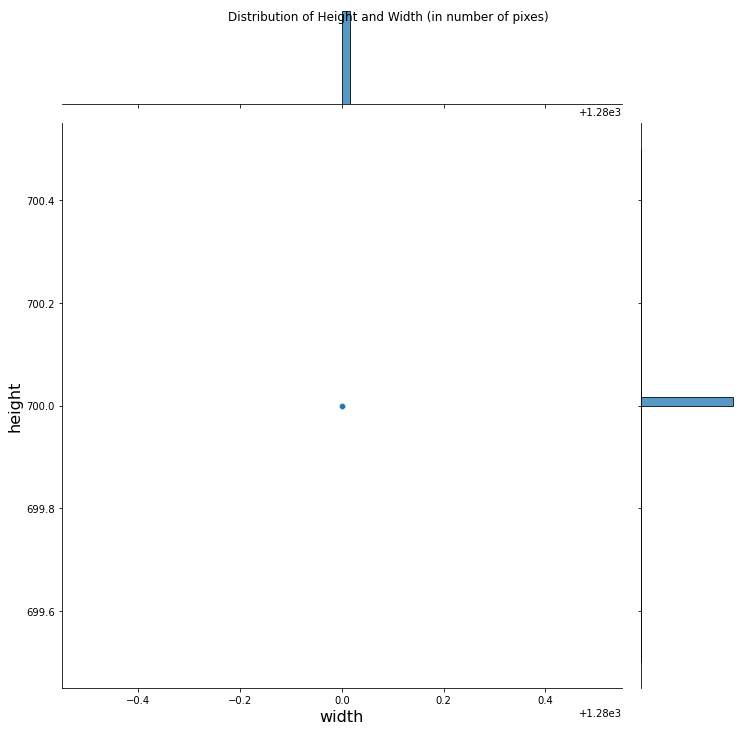

In [ ]:
number_bins = 64
img_grid = sns.jointplot(x=width_dist, y=height_dist,
                marginal_kws=dict(bins=number_bins),
                height=10)

img_grid.set_axis_labels('width', 'height', fontsize=16)
plt.suptitle("Distribution of Height and Width (in number of pixes)")

plt.show()

In [ ]:
# Gather distrbution of object height and width
obj_height_dist = []
obj_width_dist = []

for data_instance in train_image_bdd:

  for obj in data_instance['objects']:
    obj_width_dist.append(obj['bbox'][2])
    obj_height_dist.append(obj['bbox'][3])

obj_height_dist = np.array(obj_height_dist)
obj_width_dist = np.array(obj_width_dist)

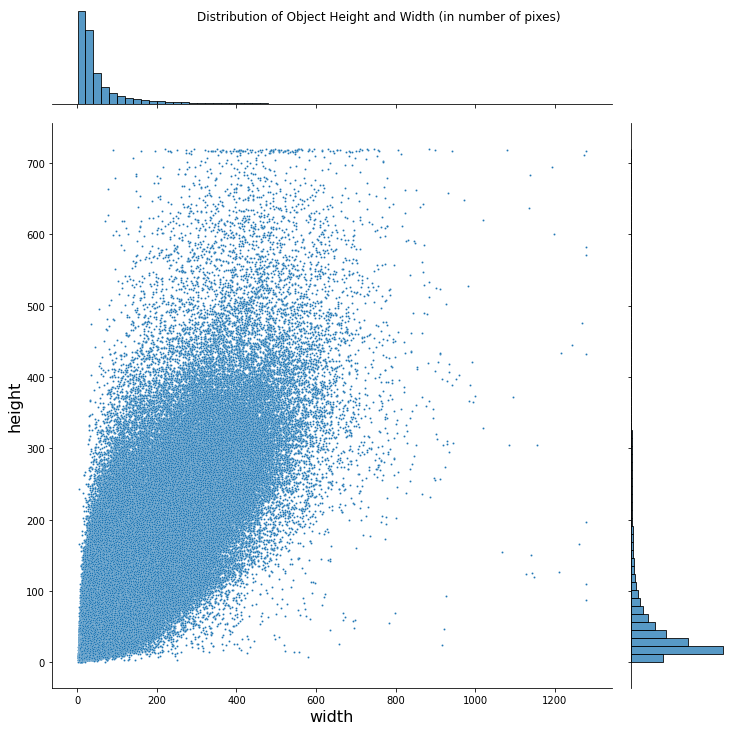

In [ ]:
number_bins = 64
img_grid = sns.jointplot(x=obj_width_dist, y=obj_height_dist,
                marginal_kws=dict(bins=number_bins, ),
                height=10, s=4)

img_grid.set_axis_labels('width', 'height', fontsize=16)
plt.suptitle("Distribution of Object Height and Width (in number of pixes)")

plt.show()

In [ ]:
# Gather all objects in a list
feature_cnt_imgs = [[], []]

for i in train_image_bdd:
  obj_arr =  i['objects']
  cat_per_img = []
  for obj in obj_arr:
    feature_cnt_imgs[0].append(obj['attributes']['truncated'])
    feature_cnt_imgs[1].append(obj['attributes']['occluded'])


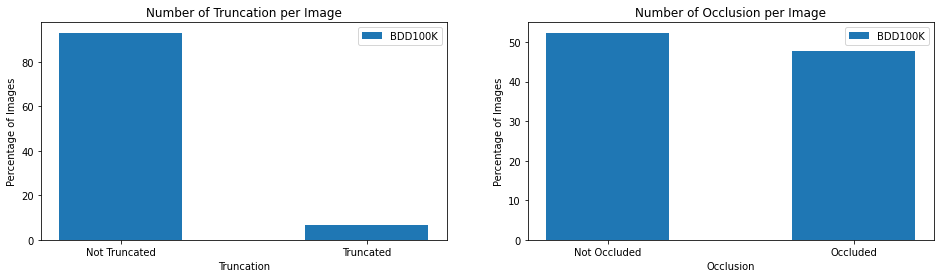

In [ ]:
features = ["Truncation", "Occlusion"]
x_ticks = [["Not Truncated", "Truncated"], 
          ["Not Occluded", "Occluded"]]

# Figure and plot
fig, ax = plt.subplots(1,2, figsize=(16,4))

for i in range(2):
  # Count number of categories in images
  obj_feature_cnts = Counter(feature_cnt_imgs[i])

  df = pandas.DataFrame.from_dict(obj_feature_cnts, orient='index')

  df[0] *= 100/len(feature_cnt_imgs[i])
  df.sort_values(by=[0], inplace=True, ascending=False)

  y = df[0].values
  x = np.arange(len(y))


  # Bar graph
  ax[i].bar(x, height=y, width=0.5, align="center")

  # Settings
  ax[i].set_title(f"Number of {features[i]} per Image")
  ax[i].set_xticks(x)
  ax[i].set_xticklabels(x_ticks[i])
  ax[i].set_xlabel(f"{features[i]}")
  ax[i].set_ylabel("Percentage of Images")
  ax[i].legend([BDD_NAME])

plt.show()

## Dataset Comparison

In [ ]:
wh = np.vstack((obj_width_dist/1200, obj_height_dist/700)).T

## K-means Clustering for Anchor Boxes

Not DBScan, since we dont want arbitrary shape rather clusters of compact shapes
So, K-means is ideal, it is also beneficial for our medium-size data set isnce its complexity is 

In [ ]:
def iou(boxes, clusters):

    """Returns iou between boxes and clusters

    Args:
      boxes: np.Array
            array of shape (N_box, 2), 1st index is box index, 2nd being width or heigh

      clusters: np.Array
                array of shape (N_cluster, 2), 1st index is cluster index, 2nd being width or heigh

    Returns:
            np.Array
            array of shape(N_box, N_cluster) iou between box and cluster
    """
    # Calculate intersection
    x = np.minimum.outer(boxes[:,0], clusters[:, 0]) 
    y = np.minimum.outer(boxes[:,1], clusters[:, 1])

    intersection = x * y

    # Calculate Union
    box_area = (boxes[:,0] * boxes[:,1]).reshape(-1,1)
    cluster_area = (clusters[:,0] * clusters[:,1]).reshape(1,-1)
    union = -intersection + box_area + cluster_area

    # IOU
    iou = np.divide(intersection, union)

    return iou

In [ ]:
def kmeans(boxes, K, dist=np.median,seed=1):

    """Returns the K cluster obtained from K-means algorithm

    Args:
      boxes: np.Array
            array of shape (N_box, 2), 1st index is box index, 2nd being width or heigh

      K: int
        parameter K of K-means algorithm
        
      dist:
        distance funct to calculate center of clusters

    Returns:
            np.Array
            array of shape(K, 2) cluster boxes 
    """
    rows = boxes.shape[0]

    distances     = np.empty((rows, K)) ## N row x N cluster
    last_clusters = np.zeros((rows,))

    np.random.seed(seed)

    # initialize the cluster centers to be k items
    clusters = boxes[np.random.choice(rows, K, replace=False)]

    while True:
        
        distances = 1 - iou(boxes, clusters)

        nearest_clusters = np.argmin(distances, axis=1)
        # print(30*"*", "\n")
        # print(clusters)

        if (last_clusters == nearest_clusters).all():
            break
            
        # Step 2: calculate the cluster centers as mean (or median) of all the cases in the clusters.
        for cluster in range(K):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters,nearest_clusters,distances

In [ ]:
kmax = 8
dist = np.mean
results = {}
for k in range(3,kmax):
    clusters, nearest_clusters, distances = kmeans(wh,k,seed=2,dist=dist)
    WithinClusterMeanDist = np.mean(distances[np.arange(distances.shape[0]),nearest_clusters])
    result = {"clusters":             clusters,
              "nearest_clusters":     nearest_clusters,
              "distances":            distances,
              "WithinClusterMeanDist": WithinClusterMeanDist}
    print("{:2.0f} clusters: mean IoU = {:5.4f}".format(k,1-result["WithinClusterMeanDist"]))
    results[k] = result

 3 clusters: mean IoU = 0.4947
 4 clusters: mean IoU = 0.5417
 5 clusters: mean IoU = 0.5672
 6 clusters: mean IoU = 0.5825
 7 clusters: mean IoU = 0.6000


/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


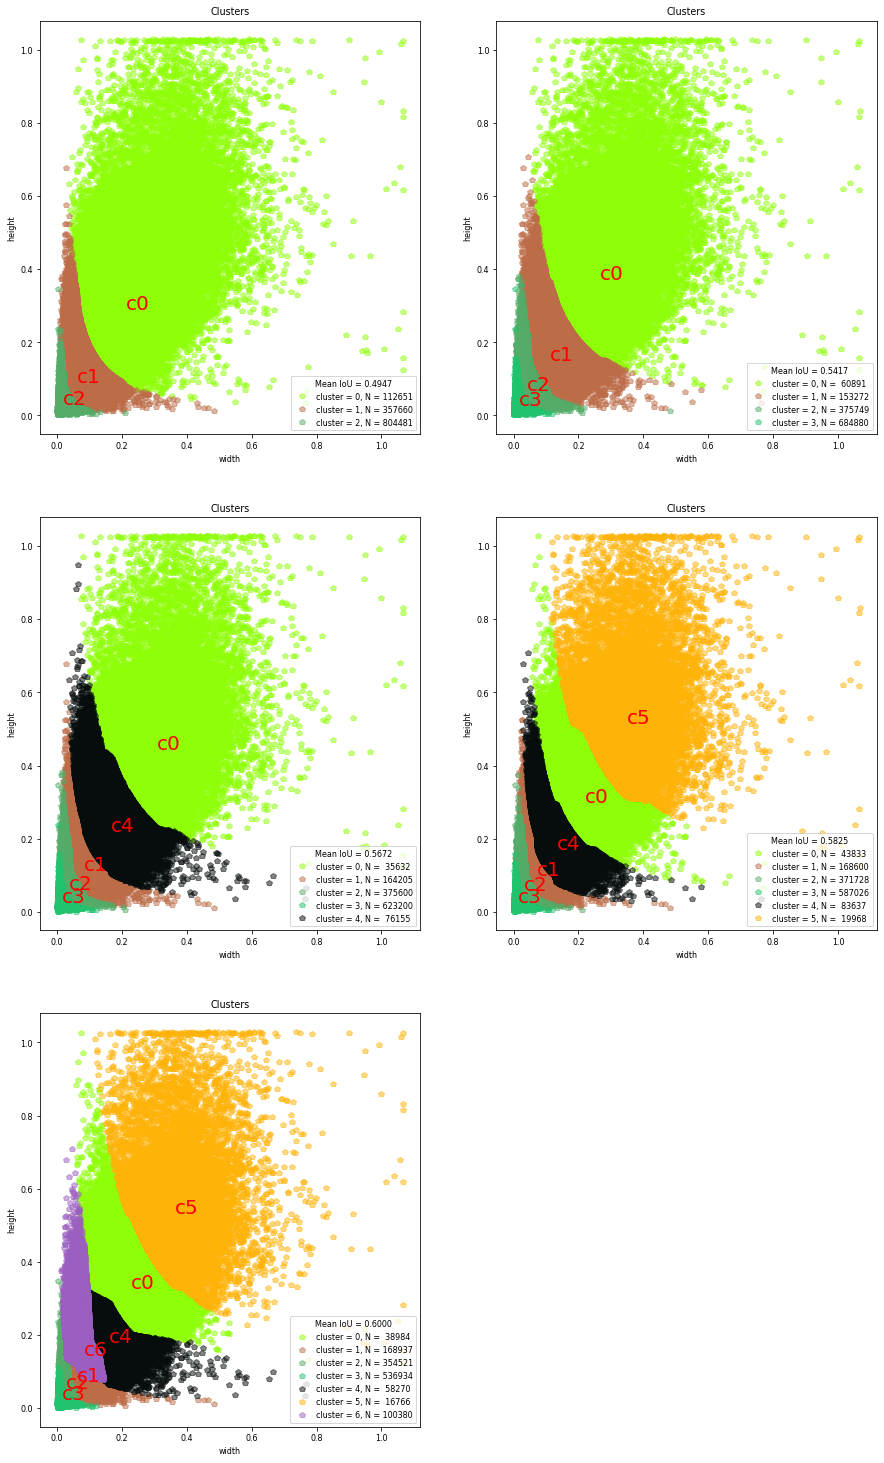

In [ ]:
def plot_cluster_result(plt, clusters, nearest_clusters, WithinClusterSumDist, wh):

  current_palette = list(sns.xkcd_rgb.values())
  # Go through each cluster results and plot it
  for cluster in np.unique(nearest_clusters):

    # Choose cluster
    cluster_mask = (nearest_clusters == cluster)

    c = current_palette[cluster]

    plt.rc('font', size=8) 
    plt.plot(wh[cluster_mask,0], wh[cluster_mask,1],"p", color=c,
                 alpha=0.5,label=f"cluster = {cluster}, N = {np.sum(cluster_mask):6.0f}")
    plt.text(clusters[cluster,0], clusters[cluster,1],
                 "c{}".format(cluster),
                 fontsize=20,color="red")
    plt.title("Clusters")
    plt.xlabel("width")
    plt.ylabel("height")
  plt.legend(title=f"Mean IoU = {WithinClusterSumDist:5.4f}")  
    



figsize = (15,35)
count =1 
fig = plt.figure(figsize=figsize)
for k in range(3,kmax):
    result               = results[k]
    clusters             = result["clusters"]
    nearest_clusters     = result["nearest_clusters"]
    WithinClusterSumDist = result["WithinClusterMeanDist"]
    
    ax = fig.add_subplot(kmax/2,2,count)
    plot_cluster_result(plt,clusters,nearest_clusters,1 - WithinClusterSumDist,wh)
    count += 1
plt.show()